<a href="https://colab.research.google.com/github/LucasMeirellesS/OrientacaoObjetosMachineLearning/blob/main/Orienta%C3%A7%C3%A3oObjetosMachinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criando uma classe para a criação de notebooks para modelos de Machine Learning

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

from sklearn import set_config
set_config(transform_output = "pandas")

In [119]:
class DFrame():

  def __init__(self, dataset, extension='csv'):
    if extension == 'csv':
      self.df = pd.read_csv(dataset)
    elif extension == 'excel':
      self.df = pd.read_excel(dataset)
    self.x = None
    self.y = None
    self.x_train = None
    self.y_train = None
    self.x_test = None
    self.y_test = None
    self.preprocessor = None
    self.pred_test = None
    self.pred_train = None


  def show(self, head = "off", num:int = None):
    if head == "off":
      display(self.df)
    elif head == "on":
      if num is not None:
        display(self.df.head(num))
      else:
        display(self.df.head())


  def analitic(self):
    print("Informações gerais:")
    display(self.df.info())
    print("")
    print("")
    print("Descrição estatística:")
    display(self.df.describe())
    print("")
    print("")
    print("Valores nulos:")
    display(self.df.isna().sum().to_frame().rename(columns ={0:"null_values"}))


  def get_categorical(self):
    return list(self.df.select_dtypes(exclude="number").columns)


  def change_type(self, type_act, type_ch):
    columns2Change = self.df.select_dtypes(type_act).columns
    for column in columns2Change:
      self.df[column] = self.df[column].astype(type_ch)


  def drop_column(self, columns:list, transformed = False):
    return self.df.drop(columns=columns, axis=1)

  def replace_value(self, column, v_act, v_ch):
    self.df[column]=self.df[column].replace(v_act, v_ch)


  def get_numeric(self):
    return list(self.df.select_dtypes(include="number"))


  def _set_x_y(self, target):
    self.x = self.drop_column(target)
    self.y = self.df[[target]]


  def set_train_test(self, target):
    self._set_x_y(target)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size = 0.30, random_state = 42)


  def trata_na(self, opcao:int, valor=None, *args):
    if opcao == 0:
      self.df.dropna(inplace=True)
    elif opcao == 1 and valor is not None:
      for i in args:
        self.df[i] = self.df[i].fillna(valor)


  def preprocessor_generator(self, num_scaler, cat_encoder):
    preprocessor = make_column_transformer(
        [num_scaler, self.get_numeric()],
        [cat_encoder, self.get_categorical()]
    )

    self.df = preprocessor.fit_transform(self.df)


  def get_results(self, model):

    model.fit(self.x_train, self.y_train)
    total_train = self.x_train.join(self.y_train, how="inner")
    total_test = self.x_test.join(self.y_test, how="inner")

    self.pred_train = model.predict(self.x_train)
    self.pred_test = model.predict(self.x_test)
    self.df["Predict"] = model.predict(self.x)

    total_train["Predict"] = self.pred_train
    total_test["Predict"] = self.pred_test

    return total_train, total_test


  def get_cm(self):

    cm = confusion_matrix(self.y_test, self.pred_test)

    cm_display = ConfusionMatrixDisplay(cm).plot()

  def get_rocauc(self, model):
    y_score = model.decision_function(self.x_test)

    fpr, tpr, _ = roc_curve(self.y_test, y_score, pos_label=model.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Testando a Classe

## Importando dataframe

In [121]:
df = DFrame("https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F75a740fb-4146-455a-8d13-6a24ba56d2c8%2Fstreaming_data.csv?table=block&id=7f01c93d-8cfd-46fb-9f2a-8f0bbd2fbaae&spaceId=6a055055-52ec-4ebb-a697-63027c951344&userId=c0845f00-59fb-4a0f-bb4a-c1e2314cd202&cache=v2")
df.show(head = "on")

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


# Observando algumas informações dos dados

In [122]:
df.analitic()

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


None



Descrição estatística:


,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000




Valores nulos:


,null_values
Age,11277
Gender,14516
Time_on_platform,21420
Devices_connected,25188
Subscription_type,25221
Num_streaming_services,68312
Num_active_profiles,0
Avg_rating,17270
Churned,16736
User_id,0


## Tratando nulos

In [123]:
df.trata_na(1, 0, "Time_on_platform", "Num_streaming_services", "Churned", "Avg_rating", "Devices_connected")
df.trata_na(0)

In [124]:
df.show(head = "on")

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,0.0,a1df3a13-9255-4d00-8a9d-20565fefaab9


## Alterando Tipo de Colunas e observando as informações

In [125]:
df.change_type(float, int)

In [126]:
df.analitic()

Informações gerais:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     36515 non-null  int64 
 1   Gender                  36515 non-null  object
 2   Time_on_platform        36515 non-null  int64 
 3   Devices_connected       36515 non-null  int64 
 4   Subscription_type       36515 non-null  object
 5   Num_streaming_services  36515 non-null  int64 
 6   Num_active_profiles     36515 non-null  int64 
 7   Avg_rating              36515 non-null  int64 
 8   Churned                 36515 non-null  int64 
 9   User_id                 36515 non-null  object
dtypes: int64(7), object(3)
memory usage: 3.1+ MB


None



Descrição estatística:


,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,36515.000000,36515.000000,36515.000000,36515.000000,36515.000000,36515.000000,36515.000000
mean,43.473422,3170.231576,2.039628,0.309434,2.993455,1.951006,0.193236
std,15.092181,2909.245246,1.820622,0.909600,1.412968,1.435179,0.394842
min,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000
50%,43.000000,2708.000000,2.000000,0.000000,3.000000,2.000000,0.000000
75%,57.000000,5741.000000,4.000000,0.000000,4.000000,3.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000




Valores nulos:


,null_values
Age,0
Gender,0
Time_on_platform,0
Devices_connected,0
Subscription_type,0
Num_streaming_services,0
Num_active_profiles,0
Avg_rating,0
Churned,0
User_id,0


## Dropando colunas

In [127]:
df.df = df.drop_column("User_id")

## Substituindo valores

In [128]:
df.replace_value("Churned", 0, "No")
df.replace_value("Churned", 1, "Yes")

In [129]:
df.show()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
0,49,Male,4700,3,Basic,0,3,0,No
1,69,Female,6107,2,Standard,0,1,2,No
2,44,Male,6374,3,Premium,1,1,1,Yes
3,26,Male,0,5,Basic,0,2,0,No
5,54,Male,3024,2,Basic,0,1,0,No
...,...,...,...,...,...,...,...,...,...
77879,45,Male,0,0,Basic,0,5,2,No
77880,47,Female,6176,0,Premium,0,2,4,No
77881,64,Female,0,5,Premium,0,1,4,Yes
77882,58,Male,1314,5,Standard,0,4,0,No


## Implementando o modelo

In [130]:
scaler = StandardScaler()
onehot = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
model = LogisticRegression()

In [131]:
df.preprocessor_generator(scaler, onehot)


In [132]:
df.df

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard,onehotencoder__Churned_Yes
0,0.366193,0.525837,0.527504,-0.340192,0.004632,-1.359435,1.0,1.0,0.0,0.0,0.0
1,1.691401,1.009474,-0.021766,-0.340192,-1.410847,0.034138,0.0,0.0,0.0,1.0,0.0
2,0.034891,1.101252,0.527504,0.759207,-1.410847,-0.662648,1.0,0.0,1.0,0.0,1.0
3,-1.157796,-1.089724,1.626045,-0.340192,-0.703107,-1.359435,1.0,1.0,0.0,0.0,0.0
5,0.697495,-0.050265,-0.021766,-0.340192,-1.410847,-1.359435,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
77879,0.101152,-1.089724,-1.120307,-0.340192,1.420112,0.034138,1.0,1.0,0.0,0.0,0.0
77880,0.233672,1.033192,-1.120307,-0.340192,-0.703107,1.427711,0.0,0.0,1.0,0.0,0.0
77881,1.360099,-1.089724,1.626045,-0.340192,-1.410847,1.427711,0.0,0.0,1.0,0.0,1.0
77882,0.962537,-0.638054,1.626045,-0.340192,0.712372,-1.359435,1.0,0.0,0.0,1.0,0.0


In [133]:
df.set_train_test("onehotencoder__Churned_Yes")

In [134]:
df.show()

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard,onehotencoder__Churned_Yes
0,0.366193,0.525837,0.527504,-0.340192,0.004632,-1.359435,1.0,1.0,0.0,0.0,0.0
1,1.691401,1.009474,-0.021766,-0.340192,-1.410847,0.034138,0.0,0.0,0.0,1.0,0.0
2,0.034891,1.101252,0.527504,0.759207,-1.410847,-0.662648,1.0,0.0,1.0,0.0,1.0
3,-1.157796,-1.089724,1.626045,-0.340192,-0.703107,-1.359435,1.0,1.0,0.0,0.0,0.0
5,0.697495,-0.050265,-0.021766,-0.340192,-1.410847,-1.359435,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
77879,0.101152,-1.089724,-1.120307,-0.340192,1.420112,0.034138,1.0,1.0,0.0,0.0,0.0
77880,0.233672,1.033192,-1.120307,-0.340192,-0.703107,1.427711,0.0,0.0,1.0,0.0,0.0
77881,1.360099,-1.089724,1.626045,-0.340192,-1.410847,1.427711,0.0,0.0,1.0,0.0,1.0
77882,0.962537,-0.638054,1.626045,-0.340192,0.712372,-1.359435,1.0,0.0,0.0,1.0,0.0


In [135]:
df.y_train

,onehotencoder__Churned_Yes
8511,1.0
59047,1.0
39869,0.0
70960,0.0
37108,0.0
...,...
35869,0.0
13266,0.0
24059,0.0
1815,0.0


In [136]:
df.x_train

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard
8511,1.293839,-1.089724,-1.120307,-0.340192,0.712372,-1.359435,1.0,0.0,0.0,1.0
59047,-1.489098,0.425466,1.626045,-0.340192,1.420112,-0.662648,1.0,0.0,0.0,1.0
39869,-1.555358,1.298557,0.527504,-0.340192,0.004632,-0.662648,1.0,0.0,0.0,1.0
70960,-0.097629,-0.052328,-0.571037,-0.340192,-0.703107,1.427711,1.0,0.0,1.0,0.0
37108,-0.760233,0.665050,-1.120307,-0.340192,-1.410847,-0.662648,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35869,-1.555358,-0.902388,-0.021766,-0.340192,1.420112,0.034138,0.0,0.0,0.0,1.0
13266,0.830016,1.038692,1.626045,-0.340192,1.420112,0.034138,0.0,0.0,1.0,0.0
24059,0.962537,0.900854,-1.120307,0.759207,-0.703107,0.730925,0.0,0.0,0.0,1.0
1815,0.498714,1.799037,-1.120307,-0.340192,-0.703107,1.427711,1.0,1.0,0.0,0.0


In [146]:
total_train, total_test =  df.get_results(model)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [147]:
total_train

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard,onehotencoder__Churned_Yes,Predict
8511,1.293839,-1.089724,-1.120307,-0.340192,0.712372,-1.359435,1.0,0.0,0.0,1.0,1.0,0.0
59047,-1.489098,0.425466,1.626045,-0.340192,1.420112,-0.662648,1.0,0.0,0.0,1.0,1.0,0.0
39869,-1.555358,1.298557,0.527504,-0.340192,0.004632,-0.662648,1.0,0.0,0.0,1.0,0.0,0.0
70960,-0.097629,-0.052328,-0.571037,-0.340192,-0.703107,1.427711,1.0,0.0,1.0,0.0,0.0,0.0
37108,-0.760233,0.665050,-1.120307,-0.340192,-1.410847,-0.662648,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35869,-1.555358,-0.902388,-0.021766,-0.340192,1.420112,0.034138,0.0,0.0,0.0,1.0,0.0,0.0
13266,0.830016,1.038692,1.626045,-0.340192,1.420112,0.034138,0.0,0.0,1.0,0.0,0.0,0.0
24059,0.962537,0.900854,-1.120307,0.759207,-0.703107,0.730925,0.0,0.0,0.0,1.0,0.0,0.0
1815,0.498714,1.799037,-1.120307,-0.340192,-0.703107,1.427711,1.0,1.0,0.0,0.0,0.0,0.0


In [148]:
total_test

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard,onehotencoder__Churned_Yes,Predict
25295,-0.031369,1.036286,0.527504,-0.340192,0.712372,-1.359435,1.0,1.0,0.0,0.0,0.0,0.0
27047,1.625140,0.393499,0.527504,-0.340192,0.712372,1.427711,0.0,0.0,0.0,1.0,0.0,0.0
74738,-0.760233,-0.796173,-1.120307,-0.340192,-1.410847,-1.359435,0.0,1.0,0.0,0.0,1.0,0.0
77654,-0.296411,1.358023,-1.120307,-0.340192,-0.703107,-1.359435,0.0,0.0,0.0,1.0,1.0,0.0
40757,-0.892754,-0.175729,1.076774,-0.340192,0.712372,-0.662648,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27779,0.631235,-1.089724,1.626045,0.759207,1.420112,-1.359435,1.0,0.0,1.0,0.0,0.0,0.0
15897,0.101152,-0.178479,-1.120307,-0.340192,0.004632,-0.662648,1.0,0.0,0.0,1.0,0.0,0.0
64364,-1.621618,0.579460,-0.571037,1.858606,1.420112,0.034138,1.0,0.0,1.0,0.0,0.0,0.0
1838,-0.760233,1.325712,-1.120307,-0.340192,0.004632,-1.359435,0.0,0.0,0.0,1.0,0.0,0.0


In [139]:
df.show()

,standardscaler__Age,standardscaler__Time_on_platform,standardscaler__Devices_connected,standardscaler__Num_streaming_services,standardscaler__Num_active_profiles,standardscaler__Avg_rating,onehotencoder__Gender_Male,onehotencoder__Subscription_type_Basic,onehotencoder__Subscription_type_Premium,onehotencoder__Subscription_type_Standard,onehotencoder__Churned_Yes,Predict
0,0.366193,0.525837,0.527504,-0.340192,0.004632,-1.359435,1.0,1.0,0.0,0.0,0.0,0.0
1,1.691401,1.009474,-0.021766,-0.340192,-1.410847,0.034138,0.0,0.0,0.0,1.0,0.0,0.0
2,0.034891,1.101252,0.527504,0.759207,-1.410847,-0.662648,1.0,0.0,1.0,0.0,1.0,0.0
3,-1.157796,-1.089724,1.626045,-0.340192,-0.703107,-1.359435,1.0,1.0,0.0,0.0,0.0,0.0
5,0.697495,-0.050265,-0.021766,-0.340192,-1.410847,-1.359435,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
77879,0.101152,-1.089724,-1.120307,-0.340192,1.420112,0.034138,1.0,1.0,0.0,0.0,0.0,0.0
77880,0.233672,1.033192,-1.120307,-0.340192,-0.703107,1.427711,0.0,0.0,1.0,0.0,0.0,0.0
77881,1.360099,-1.089724,1.626045,-0.340192,-1.410847,1.427711,0.0,0.0,1.0,0.0,1.0,0.0
77882,0.962537,-0.638054,1.626045,-0.340192,0.712372,-1.359435,1.0,0.0,0.0,1.0,0.0,0.0


In [140]:
#total_train

In [141]:
#total_test

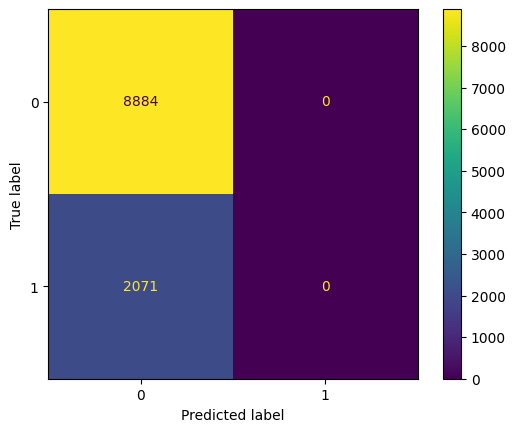

In [142]:
df.get_cm()

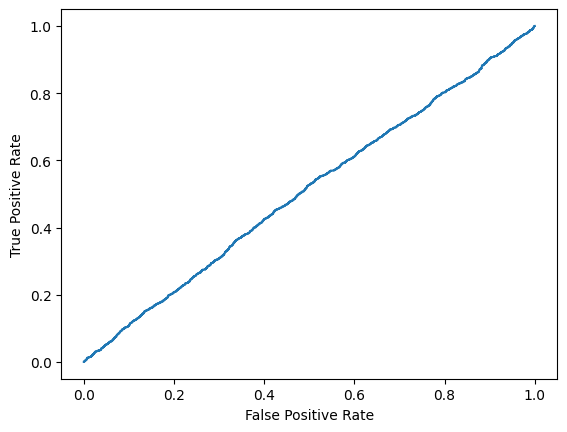

In [143]:
df.get_rocauc(model)